# Analysing the $mBasicPH\_storage$ model

## Settings

For working with the model, we first import some packages and the modelclass:

In [1]:
# In case, working directory is not set correctly
#os.chdir('C:\\Users\\mpher\\Documents\\Uni\\Master\\02_Exchange\\01_Academics\\Energy Economics of the Green Transition\\0_Final Project\EnergyEconGroupWork')

In [2]:
import os
current_directory = os.getcwd()
print(current_directory)

c:\Users\mpher\Documents\Uni\Master\02_Exchange\01_Academics\Energy Economics of the Green Transition\EnergyEconGroupWork


In [3]:
%run ./stdPackages.ipynb
from pyDbs import *

os.chdir(os.path.join(d['curr'], 'py'))

from mBasicPH_storage import *
os.chdir(d['curr'])

Next we load the database:

In [4]:
kwargs = {'variables': ['Fundamentals', 'LoadVariables', 'GeneratorsVariables','StorageVariables','TransmissionLines'],
        'maps': ['LoadMaps','GeneratorsMaps','StorageMaps','MarketMaps','hMaps'],
        'variable2D': ['HourlyVariation'],
        'scalars': ['Scalars']}

path_to_data = os.path.join(d['curr'], 'Data', 'mBasicPH_storage_Data.xlsx')

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

Convert variables to floats:

In [5]:
[db.__setitem__(var,db[var].astype(float).sort_index()) for var in db.getTypes('variable').keys()];

We need to read in heat areas manually:

In [6]:
db['g_H'] = db['id2g_H'].get_level_values('g_H').unique()

In [7]:
db['g_H']

Index(['DK_Central'], dtype='object', name='g_H')

We need to read in electricity areas manually:

In [8]:
db['g_E'] = db['id2g_E'].get_level_values('g_E').unique()

In [9]:
db['g_E']

Index(['DK'], dtype='object', name='g_E')

Collect all areas in one:

In [10]:
db['g'] = db['g_E'].copy()

## Initialze Baseline Model and Debug

In [11]:
m=mSimple(db)
m.db.symbols.keys()

dict_keys(['EmissionIntensity', 'FuelPrice', 'EmissionTax', 'Load_H', 'LoadVariation_H', 'Load_E', 'LoadVariation_E', 'GeneratingCap_E', 'FuelMix', 'OtherMC', 'E2H', 'FOM', 'GeneratingCap_H', 'effC', 'sCap', 'selfDischarge', 'effD', 'chargeCap_H', 'lineMC', 'lineFOM', 'lineCapacity', 'c_H2g_H', 'c_E2g_E', 'tech2modelTech', 'id2hvt', 'id2g_H', 'id2g_E', 'id2tech', 'g_E2g', 'g_E2g_H', 'g_H2g', 'h2HourOfTheDay', 'h2Month', 'h2Week', 'h2Weekday', 'h2Day', 'CapVariation', 'MWP_E', 'MWP_H', 'lineLoss', 'BFt', 'EmissionType', 'c_H', 'h', 'c_E', 'id', 'g_E', 'g_E_alias', 'hvt', 'g_H', 'g', 'gConnected', 'id2modelTech2tech'])

The problem was, that the storage was not correctly mapped to the heating area. Now it is included in the index below. You can check so by searching for *id_DK_Central_HS* and *id_DK_Decentral_HS*.

In [12]:
m.db['id2g_H']

MultiIndex([(        'id_DK_Central_BH_Biogas', 'DK_Central'),
            (       'id_DK_Central_BH_Biomass', 'DK_Central'),
            (        'id_DK_Central_BH_Natgas', 'DK_Central'),
            (           'id_DK_Central_BH_Oil', 'DK_Central'),
            (         'id_DK_Central_BH_Waste', 'DK_Central'),
            (        'id_DK_Central_BP_Biogas', 'DK_Central'),
            (       'id_DK_Central_BP_Biomass', 'DK_Central'),
            (          'id_DK_Central_BP_Coal', 'DK_Central'),
            (        'id_DK_Central_BP_Natgas', 'DK_Central'),
            (           'id_DK_Central_BP_Oil', 'DK_Central'),
            (         'id_DK_Central_BP_Waste', 'DK_Central'),
            (               'id_DK_Central_EP', 'DK_Central'),
            (               'id_DK_Central_GT', 'DK_Central'),
            (       'id_DK_Central_HPstandard', 'DK_Central'),
            (    'id_DK_Central_HPsurplusheat', 'DK_Central'),
            (               'id_DK_Central_HS', 'DK_Cen

## Baseline

### Solving

We then initialize and solve the model:

In [13]:
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


In [14]:
m.db.symbols.keys()

dict_keys(['EmissionIntensity', 'FuelPrice', 'EmissionTax', 'Load_H', 'LoadVariation_H', 'Load_E', 'LoadVariation_E', 'GeneratingCap_E', 'FuelMix', 'OtherMC', 'E2H', 'FOM', 'GeneratingCap_H', 'effC', 'sCap', 'selfDischarge', 'effD', 'chargeCap_H', 'lineMC', 'lineFOM', 'lineCapacity', 'c_H2g_H', 'c_E2g_E', 'tech2modelTech', 'id2hvt', 'id2g_H', 'id2g_E', 'id2tech', 'g_E2g', 'g_E2g_H', 'g_H2g', 'h2HourOfTheDay', 'h2Month', 'h2Week', 'h2Weekday', 'h2Day', 'CapVariation', 'MWP_E', 'MWP_H', 'lineLoss', 'BFt', 'EmissionType', 'c_H', 'h', 'c_E', 'id', 'g_E', 'g_E_alias', 'hvt', 'g_H', 'g', 'gConnected', 'id2modelTech2tech', 'mc', 'Generation_H', 'charge_H', 'discharge_H', 'Transmission_E', 'Generation_E', 'HourlyDemand_E', 'HourlyDemand_H', 'stored_H', 'λ_PowerToHeat', 'λ_LawOfMotion_H', 'λ_equilibrium_E', 'λ_equilibrium_H', 'λ_Generation_H', 'λ_charge_H', 'λ_discharge_H', 'λ_Transmission_E', 'λ_Generation_E', 'λ_HourlyDemand_E', 'λ_HourlyDemand_H', 'λ_stored_H', 'Welfare', 'FuelConsumption', 

Save solution for later:

In [15]:
base_db = m.db.copy()

### Plotting:

#### Intermittent Hourly Variation

In [16]:
# Find out range_names
db['CapVariation'].index.levels[1]

Index(['PV_DK', 'ROR_DK', 'SH_DK_Central', 'Standard', 'WL_DK', 'WS_DK'], dtype='object', name='hvt')

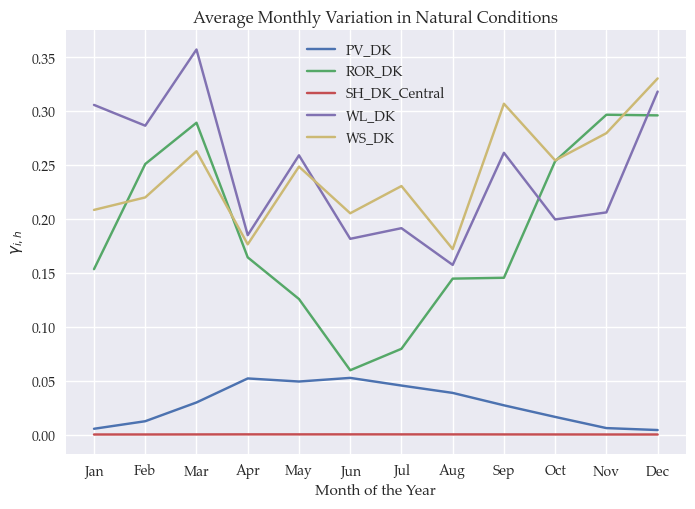

In [17]:
range_names = [0, 1, 2, 4, 5]
plants_names_intermit = db['CapVariation'].index.levels[1][range_names]

month = adj.rc_pd(m.db['h2Month'], name= 'Month')

for n, i in enumerate(plants_names_intermit):
    adjMultiIndex.applyMult(db['CapVariation'], month).loc[:,i].mean(level=['Month']).plot(label= plants_names_intermit[n])

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
plt.xticks(np.arange(start=1, stop=13, step=1), months)
plt.xlabel('Month of the Year')
plt.ylabel('$\gamma_{i,h}$')
plt.title('Average Monthly Variation in Natural Conditions')
plt.legend()
plt.savefig('monthly_variation_plot.png')

In [18]:
range_names = [0, 1, 2, 4, 5]
plants_names_intermit = db['CapVariation'].index.levels[1][range_names]

h2HourOfTheDay = adj.rc_pd(m.db['h2HourOfTheDay'], name= 'HourOfTheDay')

#for n, i in enumerate(plants_names_intermit):
#    adjMultiIndex.applyMult(db['CapVariation'], h2HourOfTheDay).loc[:,i].mean(level=['HourOfTheDay']).plot(label= plants_names_intermit[n])

hs2HourOfTheDay= np.arange(start=0, stop=24, step=1)
#plt.xticks(hs2HourOfTheDay,hs2HourOfTheDay)
#plt.ylabel('$\gamma_{i,h}$')
#plt.title('Average Hourly Variation in Natural Conditions')
#plt.legend()
#plt.savefig('hourly_variation_plot.png')

In [19]:
range_names = [2]
plants_names_intermit = db['CapVariation'].index.levels[1][range_names]

month = adj.rc_pd(m.db['h2Month'], name= 'Month')

#for n, i in enumerate(plants_names_intermit):
#    adjMultiIndex.applyMult(db['CapVariation'], month).loc[:,i].mean(level=['Month']).plot(label= plants_names_intermit[n])

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
#plt.xticks(np.arange(start=1, stop=13, step=1), months)
#plt.ylabel('$\gamma_{i,h}$')
#plt.title('Monthly Variation in Natural Conditions')
#plt.legend()
#plt.savefig('monthly_variation_SH_plot.png')

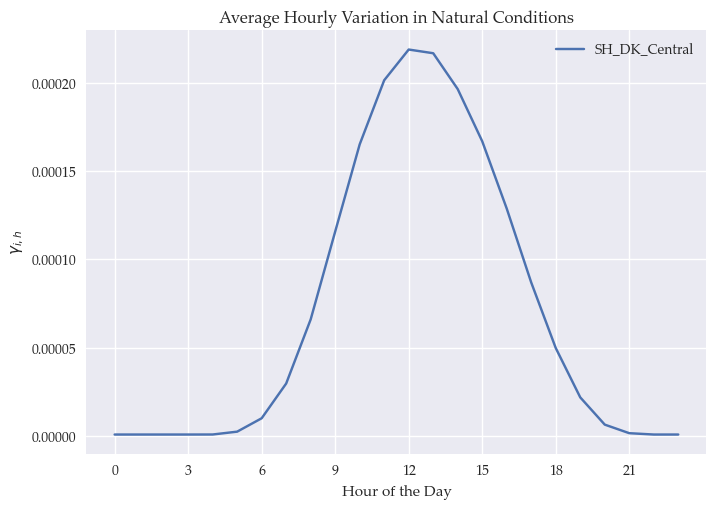

In [20]:
range_names = [2]
plants_names_intermit = db['CapVariation'].index.levels[1][range_names]

h2HourOfTheDay = adj.rc_pd(m.db['h2HourOfTheDay'], name= 'HourOfTheDay')

for n, i in enumerate(plants_names_intermit):
    adjMultiIndex.applyMult(db['CapVariation'], h2HourOfTheDay).loc[:,i].mean(level=['HourOfTheDay']).plot(label= plants_names_intermit[n])

hs2HourOfTheDay= np.arange(start=0, stop=23, step=3)
plt.xticks(hs2HourOfTheDay,hs2HourOfTheDay)
plt.xlabel('Hour of the Day')
plt.ylabel('$\gamma_{i,h}$')
plt.title('Average Hourly Variation in Natural Conditions')
plt.legend()
plt.savefig('hourly_variation_SH_plot.png')

#### Heat Generation

In [41]:
#GenH_platn_names = base_db['Generation_H'].index.levels[2]

#month = adj.rc_pd(base_db['h2Month'], name= 'Month')



#for n, i in enumerate(GenH_platn_names):
#    adjMultiIndex.applyMult(base_db['Generation_H'], month).reset_index(level=['g_H'], drop=True).loc[:,i].mean(level=['Month']).plot(label= GenH_platn_names[n])

#months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
#plt.xticks(np.arange(start=1, stop=13, step=1), months)
#plt.ylabel('MWh')
#plt.title('Heat Generation')
#plt.legend()

In [22]:
GenH_plant_names = base_db['Generation_H'].index.levels[2]

hvt = adj.rc_pd(base_db['id2hvt'], name= 'HVT')

GenH_2_hvt = adjMultiIndex.applyMult(base_db['Generation_H'], hvt).reset_index(level=['g_H'], drop=True)

month = adj.rc_pd(base_db['h2Month'], name= 'Month')

range_xyz = [2,3]
hvt_plant_names = base_db['id2hvt'].levels[1][range_xyz]

#for n, i in enumerate(hvt_plant_names):
#    adjMultiIndex.applyMult(GenH_2_hvt, month).reset_index(level=['id'], drop=True).loc[:,i].mean(level=['Month']).plot(label= hvt_plant_names[n])

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
#plt.xticks(np.arange(start=1, stop=13, step=1), months)
#plt.ylabel('MWh')
#plt.title('Intermittent Heat Generation')
#plt.legend()

In [23]:
GenH_plant_names = base_db['Generation_H'].index.levels[2]

id2tech = adj.rc_pd(base_db['id2tech'], name = 'id2tech')
GenH_id2tech = adjMultiIndex.applyMult(base_db['Generation_H'], id2tech).reset_index(level=['g_H'], drop=True)

tech2modelTech = adj.rc_pd(base_db['tech2modelTech'], name = 'tech2modelTech')
GenH_id2tech_tech2modelTech = adjMultiIndex.applyMult(GenH_id2tech, tech2modelTech)

range_tech2modelTec = [2]
names = GenH_id2tech_tech2modelTech.index.levels[3]

month = adj.rc_pd(base_db['h2Month'], name= 'Month')

#for n, i in enumerate(names):
#    adjMultiIndex.applyMult(GenH_id2tech_tech2modelTech, month).reset_index(level=['id','tech'], drop=True).loc[:,i].mean(level=['Month']).plot(label= names[n])

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
#plt.xticks(np.arange(start=1, stop=13, step=1), months)
#plt.ylabel('MWh')
#plt.title('Intermittent Heat Generation')
#plt.legend()

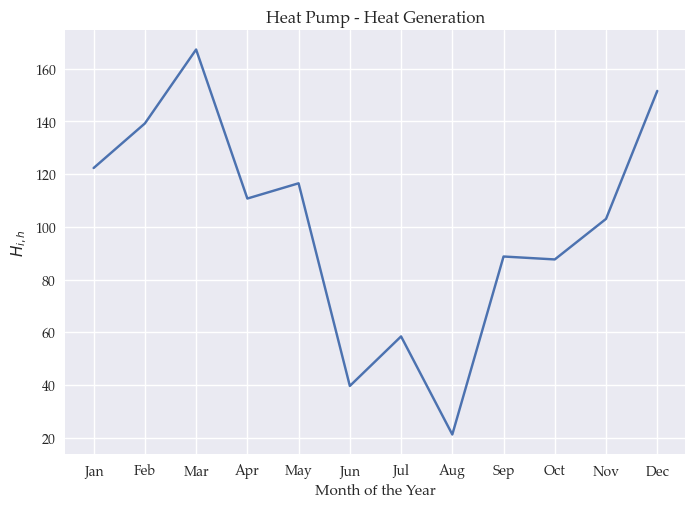

In [48]:
GenH_plant_names = base_db['Generation_H'].index.levels[2]

id2tech = adj.rc_pd(base_db['id2tech'], name = 'id2tech')
GenH_id2tech = adjMultiIndex.applyMult(base_db['Generation_H'], id2tech).reset_index(level=['g_H'], drop=True)

tech2modelTech = adj.rc_pd(base_db['tech2modelTech'], name = 'tech2modelTech')
GenH_id2tech_tech2modelTech = adjMultiIndex.applyMult(GenH_id2tech, tech2modelTech)

range_tech2modelTec = [2]
names = GenH_id2tech_tech2modelTech.index.levels[3][range_tech2modelTec]

month = adj.rc_pd(base_db['h2Month'], name= 'Month')

for n, i in enumerate(names):
    adjMultiIndex.applyMult(GenH_id2tech_tech2modelTech, month).reset_index(level=['id','tech'], drop=True).loc[:,i].mean(level=['Month']).plot()

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
plt.xticks(np.arange(start=1, stop=13, step=1), months)
plt.ylabel('$H_{i,h}$')
plt.xlabel('Month of the Year')
plt.title('Heat Pump - Heat Generation')
plt.savefig('baseline_monthly_generation_H_HP_plot.png')

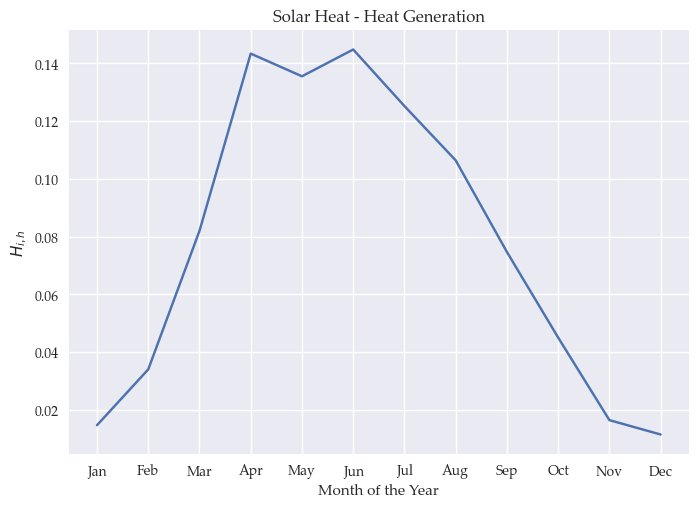

In [49]:
id2tech = adj.rc_pd(base_db['id2tech'], name = 'id2tech')
GenH_id2tech = adjMultiIndex.applyMult(base_db['Generation_H'], id2tech).reset_index(level=['g_H'], drop=True)

range_id2tech = [21]
names_id2tech = GenH_id2tech.index.levels[2][range_id2tech]

month = adj.rc_pd(base_db['h2Month'], name= 'Month')

for n, i in enumerate(names_id2tech):
    adjMultiIndex.applyMult(GenH_id2tech, month).reset_index(level=['id'], drop=True).loc[:,i].mean(level=['Month']).plot()

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
plt.xticks(np.arange(start=1, stop=13, step=1), months)
plt.ylabel('$H_{i,h}$')
plt.xlabel('Month of the Year')
plt.title('Solar Heat - Heat Generation')
plt.savefig('baseline_monthly_generation_H_SH_plot.png')

In [ ]:
#month = adj.rc_pd(m.db['h2Month'], name= 'Month')

#adjMultiIndex.applyMult(base_db['Generation_H'], month).sum(level=['Month']).plot(legend=False)

#months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
#plt.xticks(np.arange(start=1, stop=13, step=1), months)
#plt.ylabel('MWh')
#plt.title('Total Heat Generation')

#### Electricity Generation

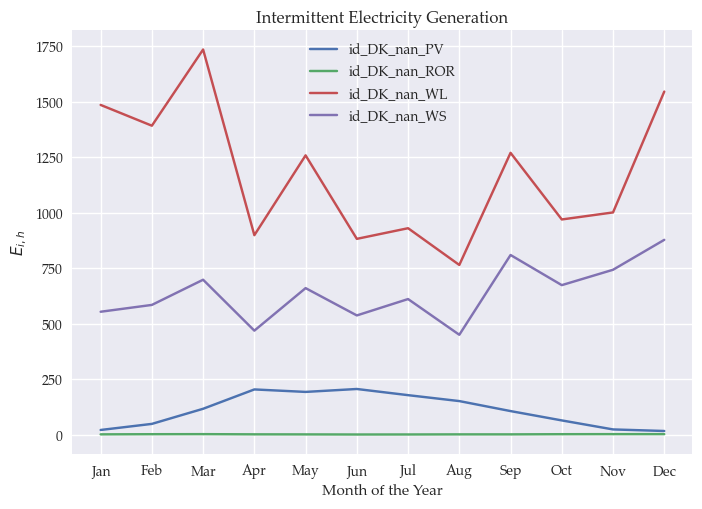

In [47]:
range_E = [18,19,20,21]
plants_names_intermit_E = base_db['Generation_E'].index.levels[2][range_E]

month = adj.rc_pd(m.db['h2Month'], name= 'Month')

for n, i in enumerate(plants_names_intermit_E):
    adjMultiIndex.applyMult(base_db['Generation_E'], month).reset_index(level=['g_E'], drop=True).loc[:,i].mean(level=['Month']).plot(label= plants_names_intermit_E[n])

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
plt.xticks(np.arange(start=1, stop=13, step=1), months)
plt.xlabel('Month of the Year')
plt.ylabel('$E_{i,h}$')
plt.title('Intermittent Electricity Generation')
plt.legend()
plt.savefig('baseline_monthly_generation_E_intermittent_plot.png')

#### Marginal System Costs H

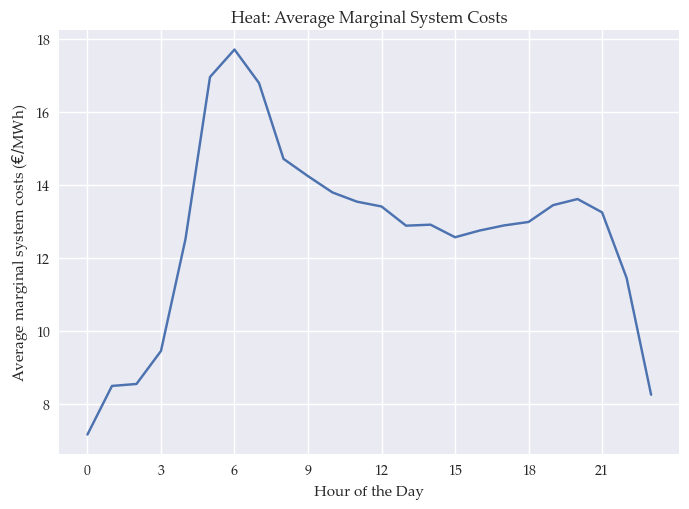

In [29]:
# Save as df
marginalSystemCosts_H_df = base_db['marginalSystemCosts_H'].to_frame().reset_index().rename(columns={0: 'MarginalSystemCosts'})

# Add hour mapping to df
marginalSystemCosts_H_df = marginalSystemCosts_H_df.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
marginalSystemCosts_H_df.groupby('HourOfTheDay')['MarginalSystemCosts'].mean().plot()

hs2HourOfTheDay= np.arange(start=0, stop=23, step=3)
plt.xticks(hs2HourOfTheDay,hs2HourOfTheDay)

plt.xlabel('Hour of the Day')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Heat: Average Marginal System Costs')
plt.savefig('baseline_hourly_systemcosts_H_plot.png')
plt.show()

In [30]:
# Save as df
marginalSystemCosts_H_df = base_db['marginalSystemCosts_H'].to_frame().reset_index().rename(columns={0: 'MarginalSystemCosts'})

# Add hour mapping to df
marginalSystemCosts_H_df = marginalSystemCosts_H_df.reset_index().merge(m.db['h2Day'].to_frame(index=False))

#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
#marginalSystemCosts_H_df.groupby('Day')['MarginalSystemCosts'].mean().plot()
#plt.xlabel('Day of the Year')
#plt.ylabel('Average marginal system costs ($€/$MWh)')
#plt.title('Heat: Average Marginal System Costs')
#plt.show()

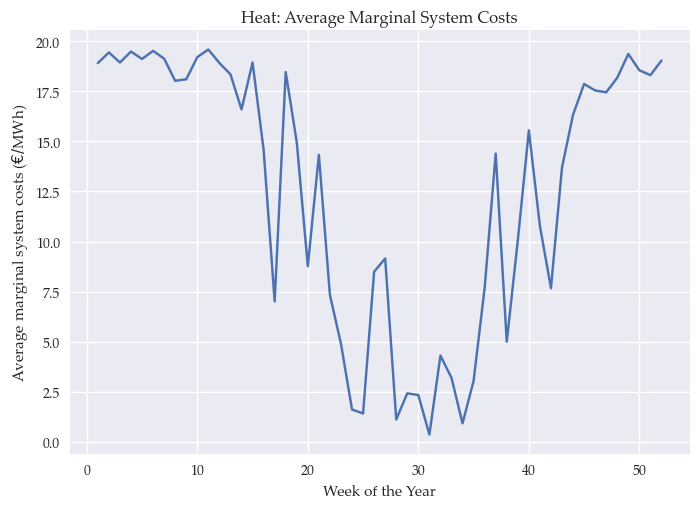

In [31]:
# Save as df
marginalSystemCosts_H_df = base_db['marginalSystemCosts_H'].to_frame().reset_index().rename(columns={0: 'MarginalSystemCosts'})

# Add hour mapping to df
marginalSystemCosts_H_df = marginalSystemCosts_H_df.reset_index().merge(m.db['h2Week'].to_frame(index=False))

#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
marginalSystemCosts_H_df.groupby('Week')['MarginalSystemCosts'].mean().plot()
plt.xlabel('Week of the Year')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Heat: Average Marginal System Costs')
plt.savefig('baseline_weekly_systemcosts_H_plot.png')
plt.show()

#### Storage Technology

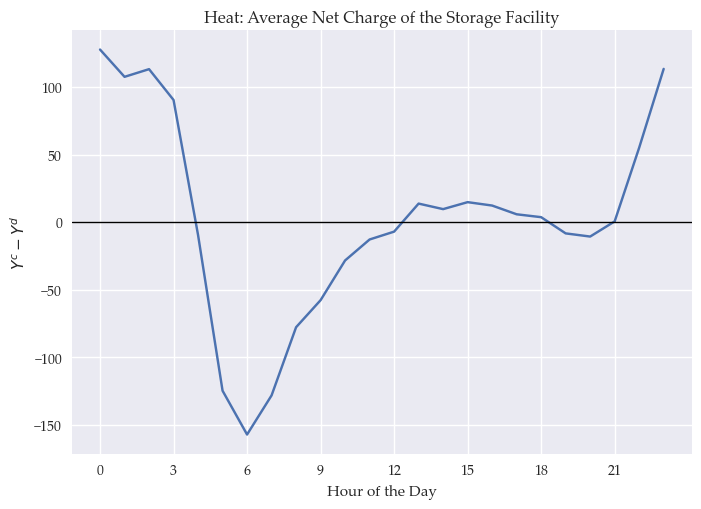

In [32]:
# Make dataframe
charge = (base_db['charge_H'].droplevel('id')).to_frame(name='charge')
discharge = (base_db['discharge_H'].droplevel('id')).to_frame(name='discharge')

df_Y = pd.concat([charge, discharge], axis=0).groupby('h').agg('sum')
df_Y['result_column'] = df_Y['charge'] - df_Y['discharge']

# Make new dataframe with time mappings
df = df_Y['result_column'].reset_index().merge(base_db['h2HourOfTheDay'].to_frame(index=False))
df = df.drop(columns=['h'])

# Make plot
fig, ax = plt.subplots()
df.groupby('HourOfTheDay').mean().plot(xlabel='Hour of the Day', ylabel=r'$Y^c - Y^d$', ax=ax, legend=False)
hs2HourOfTheDay= np.arange(start=0, stop=23, step=3)
ax.axhline(y=0, color='black', linewidth=1, linestyle='-')
plt.xticks(hs2HourOfTheDay,hs2HourOfTheDay)
plt.title('Heat: Average Net Charge of the Storage Facility')
plt.savefig('baseline_hourly_net_charge_H_plot.png')
plt.show()


In [33]:
# Save as df
charge_df = base_db['charge_H'].to_frame().reset_index().rename(columns={0: 'charge'})

# Add hour mapping to df
charge_df = charge_df.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
#charge_df.groupby('HourOfTheDay')['charge'].mean().plot()
#plt.xlabel('Average hour of the day')
#plt.ylabel('Average charging (MW)')
#plt.xticks(tick_positions, tick_positions)
#plt.title('Average charging')
#plt.show()

In [34]:
# Save as df
discharge_df = base_db['discharge_H'].to_frame().reset_index().rename(columns={0: 'discharge'})

# Add hour mapping to df
discharge_df = discharge_df.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
#discharge_df.groupby('HourOfTheDay')['discharge'].mean().plot()
#plt.xlabel('Average hour of the day')
#plt.ylabel('Average discharging (MW)')
#plt.xticks(tick_positions, tick_positions)
#plt.title('Average discharging')
#plt.show()

## Counterfactual Scenarios

### Solving

In the following, we will run an experiment where we are exogenously increase the capacity of the storage technology from the baseline levels. We exogenously take the size of the large hot water tank recently built in Germany ([Vattenfall's press release](https://group.vattenfall.com/press-and-media/newsroom/2022/germanys-largest-heat-storage-in-the-starting-blocks)) as the maximum size of our counterfactual scenarios. The tank has a size of 56'000 $m^3$. We then exogenously insert this number in cell *C30* in the file *\EnergyEconGroupWork\DownloadDataForDK\ModelData\technology_datasheet_for_energy_storage.xlsx* in sheet *141 Large hot water tank Berlin* to get the maximum values for $GeneratingCap\_H$, $chargeCap\_H$ and $sCap$. Note that we keep the energy to heat ratio constant at 60 hours (the time it takes to fully load or deload the tank).

We will also be extracting the following variables:

In [35]:
m.db['marginalEconomicValue'].to_excel('marginalEconomicValue.xlsx')

In [36]:
extract = ['marginalSystemCosts_H','charge_H','discharge_H','Welfare', 'marginalEconomicValue', 'λ_stored_H','λ_discharge_H','λ_charge_H']

In [37]:
# Setting
#E2H = 60.344828 # The "energy storage to heat"-ratio/storage duration
#maxcap = 53.8
loop = pd.Index(range(5), name = 'loop')
v0_GCap = pd.Series(base_db['GeneratingCap_H'], index = getTechs(['HS'],m.db))
vT_GCap = pd.Series(624.9, index = v0_GCap.index)
v0_SCap = pd.Series(base_db['sCap'], index = getTechs(['HS'],m.db))
vT_SCap = pd.Series(37495, index = v0_GCap.index)

grid_GCap = adjMultiIndex.addGrid(v0_GCap,vT_GCap,loop,'GeneratingCapacity').astype(int)
grid_SCap = adjMultiIndex.addGrid(v0_SCap,vT_SCap,loop,'sCap').astype(int)

In [38]:
grid_GCap

loop  id              
0     id_DK_Central_HS    207
1     id_DK_Central_HS    311
2     id_DK_Central_HS    416
3     id_DK_Central_HS    520
4     id_DK_Central_HS    624
Name: GeneratingCapacity, dtype: int32

In [39]:
grid_SCap

loop  id              
0     id_DK_Central_HS    12431
1     id_DK_Central_HS    18697
2     id_DK_Central_HS    24963
3     id_DK_Central_HS    31229
4     id_DK_Central_HS    37495
Name: sCap, dtype: int32

We now run the counterfactual scenarios:

In [40]:
solution = m.loopSolveExtract(loop, [grid_GCap, grid_SCap], extract)

### Heat: Average Marginal System Costs

In [ ]:
loop_id=loop[[0,1,2,3,4]]

In [ ]:
# Add hour mapping to df
marginalSystemCosts_H_df_loop = adj.rc_pd(solution['marginalSystemCosts_H'],loop_id).unstack('loop').reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Deleta h column as it messes up plotting
marginalSystemCosts_H_df_loop = marginalSystemCosts_H_df_loop.drop('h', axis=1)

# Plot the subset Series
marginalSystemCosts_H_df_loop.groupby('HourOfTheDay').mean().plot()
plt.xlabel('Average hour of the day')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Counterfactual Scenarios: Heat - Average marginal system costs')
plt.show()

In [ ]:
# Add hour mapping to df
marginalSystemCosts_H_df_loop_week = adj.rc_pd(solution['marginalSystemCosts_H'],loop_id).unstack('loop').reset_index().merge(m.db['h2Week'].to_frame(index=False))

# Deleta h column as it messes up plotting
marginalSystemCosts_H_df_loop_week = marginalSystemCosts_H_df_loop_week.drop('h', axis=1)

# Plot the subset Series
marginalSystemCosts_H_df_loop_week.groupby('Week').mean().plot()
plt.xlabel('Average week of the year')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Counterfactual Scenarios: Heat - Average marginal system costs')
plt.show()

In [ ]:
# Add hour mapping to df
marginalSystemCosts_H_df_loop_month = adj.rc_pd(solution['marginalSystemCosts_H'],loop_id).unstack('loop').reset_index().merge(m.db['h2Month'].to_frame(index=False))

# Deleta h column as it messes up plotting
marginalSystemCosts_H_df_loop_month = marginalSystemCosts_H_df_loop_month.drop('h', axis=1)

# Plot the subset Series
marginalSystemCosts_H_df_loop_month.groupby('Month').mean().plot()
plt.xlabel('Average month of the year')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Counterfactual Scenarios: Heat - Average marginal system costs')
plt.show()

### Electricity: Average Marginal System Costs

In [ ]:
# Add hour mapping to df
marginalSystemCosts_E_df_loop = adj.rc_pd(solution['marginalSystemCosts_E'],loop_id).unstack('loop').reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Deleta h column as it messes up plotting
marginalSystemCosts_E_df_loop = marginalSystemCosts_E_df_loop.drop('h', axis=1)

# Plot the subset Series
marginalSystemCosts_E_df_loop.groupby('HourOfTheDay').mean().plot()
plt.xlabel('Average hour of the day')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Counterfactual Scenarios: Electricity - Average marginal system costs')
plt.show()

In [ ]:
# Add hour mapping to df
marginalSystemCosts_E_df_loop_week = adj.rc_pd(solution['marginalSystemCosts_E'],loop_id).unstack('loop').reset_index().merge(m.db['h2Week'].to_frame(index=False))

# Deleta h column as it messes up plotting
marginalSystemCosts_E_df_loop_week = marginalSystemCosts_E_df_loop_week.drop('h', axis=1)

# Plot the subset Series
marginalSystemCosts_E_df_loop_week.groupby('Week').mean().plot()
plt.xlabel('Average week of the year')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Counterfactual Scenarios: Electricity - Average marginal system costs')
plt.show()

In [ ]:
# Add hour mapping to df
marginalSystemCosts_E_df_loop_month = adj.rc_pd(solution['marginalSystemCosts_E'],loop_id).unstack('loop').reset_index().merge(m.db['h2Month'].to_frame(index=False))

# Deleta h column as it messes up plotting
marginalSystemCosts_E_df_loop_month = marginalSystemCosts_E_df_loop_month.drop('h', axis=1)

# Plot the subset Series
marginalSystemCosts_E_df_loop_month.groupby('Month').mean().plot()
plt.xlabel('Average month of the year')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Counterfactual Scenarios: Electricity - Average marginal system costs')
plt.show()

### Net Charging

#### Charging

In [ ]:
# Add hour mapping to df
charge_df_loop = adj.rc_pd(solution['charge_H'],loop_id).unstack('loop').reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Deleta h column as it messes up plotting
charge_df_loop = charge_df_loop.drop('h', axis=1)

# Plot the subset Series
charge_df_loop.groupby('HourOfTheDay').mean().plot()
plt.xlabel('Average hour of the day')
plt.ylabel('Average charging (MW)')
plt.title('Counterfactual Scenarios: Average charging')
plt.show()

In [ ]:
# Add hour mapping to df
charge_df_loop_week = adj.rc_pd(solution['charge_H'],loop_id).unstack('loop').reset_index().merge(m.db['h2Week'].to_frame(index=False))

# Deleta h column as it messes up plotting
charge_df_loop_week = charge_df_loop_week.drop('h', axis=1)

# Plot the subset Series
charge_df_loop_week.groupby('Week').mean().plot()
plt.xlabel('Average week of the year')
plt.ylabel('Average charging (MW)')
plt.title('Counterfactual Scenarios: Average charging')
plt.show()

In [ ]:
# Add hour mapping to df
charge_df_loop_month = adj.rc_pd(solution['charge_H'],loop_id).unstack('loop').reset_index().merge(m.db['h2Month'].to_frame(index=False))

# Deleta h column as it messes up plotting
charge_df_loop_month = charge_df_loop_month.drop('h', axis=1)

# Plot the subset Series
charge_df_loop_month.groupby('Month').mean().plot()
plt.xlabel('Average month of the year')
plt.ylabel('Average charging (MW)')
plt.title('Counterfactual Scenarios: Average charging')
plt.show()

#### Discharging

In [ ]:
# Add hour mapping to df
discharge_df_loop = adj.rc_pd(solution['discharge_H'],loop_id).unstack('loop').reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Deleta h column as it messes up plotting
discharge_df_loop = discharge_df_loop.drop('h', axis=1)

# Plot the subset Series
discharge_df_loop.groupby('HourOfTheDay').mean().plot()
plt.xlabel('Average hour of the day')
plt.ylabel('Average discharging (MW)')
plt.title('Counterfactual Scenarios: Average discharging')
plt.show()